In [1]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.ecco_utils import resample_to_latlon, UEVNfromUXVY
from utils.utils import conversion, plot_pcolor, swap_llc270_vector_tiles, plot_scatter, interpolate_cartesian_grid, rotate_vector_field, generate_pastel_cmap
from utils import utils
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
import os
import sys
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xarray as xr
import xgcm

import matplotlib as mpl
cmap_bwr = mpl.colormaps.get_cmap('bwr')
cmap_magma = mpl.colormaps.get_cmap('magma_r')
cmap_bwr.set_bad(color='gray') # sets "bad" (i.e., NaNs) to be colored in gray
cmap_magma.set_bad(color='gray') # sets "bad" (i.e., NaNs) to be colored in gray

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

/scratch/somanshu/DeepCarbonMapping/venv_cm/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
fldList_3d = ['TRAC01','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01','cDIC','cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN','oceFWflx','SFLUX','TFLUX','oceSPflx','oceQsw','fluxCO2','gDICsurf',
           'gDICEpr','gALKEpr','gNO3Epr','gNO2Epr','gNH4Epr','gO2Epr','gPO4Epr','gFeTEpr','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14]

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

#### Integrating accross timesteps

In [3]:
# Getting the timestep values
timestep_list = [path.split(".")[1] for path in glob(f"{path_3d}/*.meta")]
timestep_list.sort()

timestep_num_list = [int(item) for item in timestep_list]

timestep_delta = np.diff(np.array(timestep_num_list), prepend=timestep_num_list[0])
len(timestep_delta)

378

In [4]:
# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/XC"))
lat = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/YC"))
dxc = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/DXC"))
dyc = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/DYC"))
hfacc = utils.transp_tiles_3d(MITgcmutils.mds.rdmds(f"{path_grid}/hFacC"))

cs = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/AngleCS"))    # cosine of grid angle
sn = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/AngleSN"))    # sine of grid angle

lon_g = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/XG"))
lat_g = utils.transp_tiles(MITgcmutils.mds.rdmds(f"{path_grid}/YG"))

# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

timestep_list = [path.split(".")[1] for path in glob(f"{path_2d}/*.data")]
timestep_list.sort()

# Checking to see if variable already exist. wont run the loop if yes==============================================
if os.path.exists("outputs/data/time_integrated_variables_final.npy"):
    print("time_integrated_variables_final.npy already exists. Skipping this cell.")
    time_integrated_variables_final = np.load("outputs/data/time_integrated_variables_final.npy")
    lon_cart = np.load("outputs/data/lon_cart.npy")
    lat_cart = np.load("outputs/data/lat_cart.npy")
# ===================================================================================================================

else:
    # Initialize sum with checkpointing piece ==========================================================================
    checkpoint_list = [int(path.split("_")[5].split(".")[0]) for path in glob(f"outputs/data/checkpoints/time_integrated_variables_final_checkpoint_*.npy")]
    if len(checkpoint_list) > 0:
        checkpoint_list.sort()
        checkpoint_val = checkpoint_list[-1]
        variables_cart_sum_timesteps = np.load(f"outputs/data/checkpoints/time_integrated_variables_final_checkpoint_{checkpoint_val}.npy")
        print(f"Resuming from checkpoint {checkpoint_val}")
    else:
        checkpoint_val = -1  # No checkpoint exists, start from scratch
        variables_cart_sum_timesteps = None
    # ===================================================================================================================
                
    for i,(timestep,delta_val) in enumerate(zip(timestep_list,timestep_delta)):
        # checkpointing piece ==========================================================================
        if i <= checkpoint_val:
            continue
        # ==============================================================================================
        
        # print(f"Started running for time step: {timestep}")
        # import 2d and 3d variables ==========================================================================
        d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.{timestep}",rec=variable_selection_2d)
        d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.{timestep}",rec=variable_selection_3d)
        
        # fixing import issues
        for var in range(d_3.shape[0]):
            d_3[var] = utils.transp_tiles_3d(d_3[var])

        for var in range(d_2.shape[0]):
            d_2[var] = utils.transp_tiles(d_2[var])
        
        # Fixing the rotation of the vector fields for 'ADVxTr01','ADVyTr01','DFxETr01','DFyETr01'
        U_east, V_north = rotate_vector_field(d_3[1], d_3[2], cs, sn, manual_interp=False)
        df_east, df_north = rotate_vector_field(d_3[4], d_3[5], cs, sn, manual_interp=False)

        d_3[1] = U_east     # replacing ADVxTr01
        d_3[2] = V_north    # replacing ADVyTr01
        d_3[4] = df_east    # replacing DFxETr01
        d_3[5] = df_north   # replacing DFyETr01
        # =========================================================================================================
        
        # Calculate the x and y direction differences==============================================================
        d_3[1] = utils.pad_diff_faces(d_3[1],direction="x")
        d_3[2] = utils.pad_diff_faces(d_3[2],direction="y")
        d_3[4] = utils.pad_diff_faces(d_3[4],direction="x")
        d_3[5] = utils.pad_diff_faces(d_3[5],direction="y")
        
        # =========================================================================================================
        
        # Conversion ===============================================================================================
        # convert 3D variables into standard units
        for var_idx in range(12):
            d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
        
        # convert 2D variables into standard units
        for var_idx in range(2):
            d_2[var_idx] = conversion(d_2[var_idx],variable_names[len(variable_selection_3d)+var_idx],dxc=dxc,dyc=dyc,drf=drf,hfacc=hfacc)
        # =========================================================================================================
    
        # FLattening ==============================================================================================
        # Flatten 3D variables upto 100m
        idx_top_100m = np.where(depth_c>=-100)[0] # getting index of top 100m depth
        
        # Integrate across Depth=====================================================================================
        delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
        flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m
        # ===========================================================================================================
        
        # Conversion into Cratesian grid ============================================================================
        combined_data = np.concatenate((flattened_d3, d_2), axis=0) # combine data
        
        # create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
        mask = combined_data[0]==0
        combined_data[:,mask] = np.nan
        
        # Interpolating the curvilinear line to the cartesian plane
        results = []
        for variable in range(combined_data.shape[0]):  
            lon_cart,lat_cart,variables_cart = interpolate_cartesian_grid(lon,lat,combined_data[variable])
            results.append(variables_cart)

        variables_cart = np.stack(results, axis=0)
        if variables_cart_sum_timesteps is None: variables_cart_sum_timesteps = np.zeros(shape=variables_cart.shape) # Initialize the variable on the first run of the loop
        # =======================================================================================================
        
        variables_cart_sum_timesteps += (variables_cart * delta_val)
        
        
        if i%50 == 0:
            print(f"Saving iteration {i}")
            np.save(f"outputs/data/checkpoints/time_integrated_variables_final_checkpoint_{i}.npy", variables_cart_sum_timesteps)
        if i%20==0:
            print(f"finished {i}. Current timestep: {timestep}")
    
    time_integrated_variables_final = variables_cart_sum_timesteps/sum(timestep_delta)
    np.save("outputs/data/time_integrated_variables_final.npy", time_integrated_variables_final)
    np.save("outputs/data/lon_cart.npy", lon_cart)
    np.save("outputs/data/lat_cart.npy", lat_cart)

time_integrated_variables_final.npy already exists. Skipping this cell.


In [22]:
for i in range(3):
    print(variable_names[i],":")
    print(np.nanmax(time_integrated_variables_final[i+1]))
    print(np.nanmin(time_integrated_variables_final[i+1]),"\n")

TRAC01 :
194625474035299.2
-182445817499241.9 

ADVxTr01 :
192597104863579.3
-310532953773614.1 

ADVyTr01 :
315384741120206.3
-274315947210703.75 



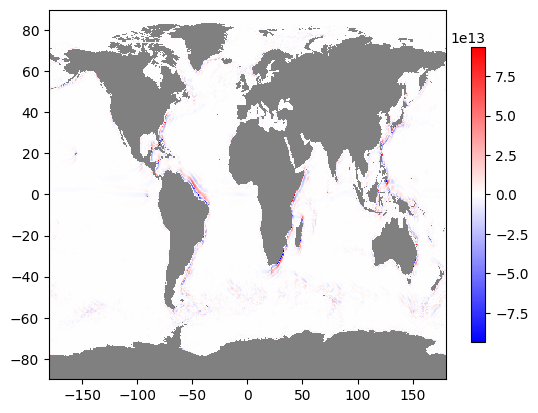

In [10]:
from utils.utils import plot_pcolor
adv = time_integrated_variables_final[1] + time_integrated_variables_final[2] 

vmax = np.nanmax(np.absolute(adv)) * 0.5
vmin=-vmax
p=plt.pcolormesh(lon_cart,lat_cart,adv,cmap=cmap_bwr,vmin=vmin,vmax=vmax)
cbar = plt.colorbar(p, orientation='vertical', shrink=0.8)

In [43]:
for var in range(time_integrated_variables_final.shape[0]):
    print(variable_names[var])
    print(np.nanmax(time_integrated_variables_final[var]))
    print(np.nanmin(time_integrated_variables_final[var]),"\n")

TRAC01
2.334489196744176e-05
9.723994081095368e-07 

ADVxTr01
194625474035299.2
-182445817499241.9 

ADVyTr01
192597104863579.3
-310532953773614.1 

ADVrTr01
315384741120206.3
-274315947210703.75 

DFxETr01
28844781409.21282
-35627128194.070816 

DFyETr01
40713571041.86585
-28717031340.19783 

DFrETr01
42086783976.122604
-196191756536.4904 

DFrITr01
664962063516.1006
-115534117136.91835 

cDIC_PIC
1603479487.0136652
0.0 

rDIC_DOC
15266079920.523811
7698.3919328781285 

rDIC_POC
1669454876.1800354
4.799529816968682e-08 

dDIC_PIC
26638600.64781265
0.0 

fluxCO2
66987531296.570625
-98166725934.55336 

gDICEpr
207501035787.4885
-1793245034326.1108 



In [8]:
for var in range(time_integrated_variables_final.shape[0]):
    print(variable_names[var])
    print(np.nanmax(time_integrated_variables_final[var])/10e15)
    print(np.nanmin(time_integrated_variables_final[var])/10e15,"\n")

TRAC01
2.334489196744176e-21
9.723994081095368e-23 

ADVxTr01
0.010470611874542835
-0.01581473674061817 

ADVyTr01
0.009157315186881386
-0.011563907835876705 

ADVrTr01
0.03153847411202063
-0.027431594721070374 

DFxETr01
2.550872581033344e-06
-2.8844781409212817e-06 

DFyETr01
2.4647888596217692e-06
-2.5432659772891224e-06 

DFrETr01
4.20867839761226e-06
-1.961917565364904e-05 

DFrITr01
6.649620635161006e-05
-1.1553411713691835e-05 

cDIC_PIC
1.6034794870136652e-07
0.0 

rDIC_DOC
1.526607992052381e-06
7.698391932878129e-13 

rDIC_POC
1.6694548761800353e-07
4.799529816968682e-24 

dDIC_PIC
2.663860064781265e-09
0.0 

fluxCO2
6.698753129657063e-06
-9.816672593455336e-06 

gDICEpr
2.075010357874885e-05
-0.00017932450343261108 



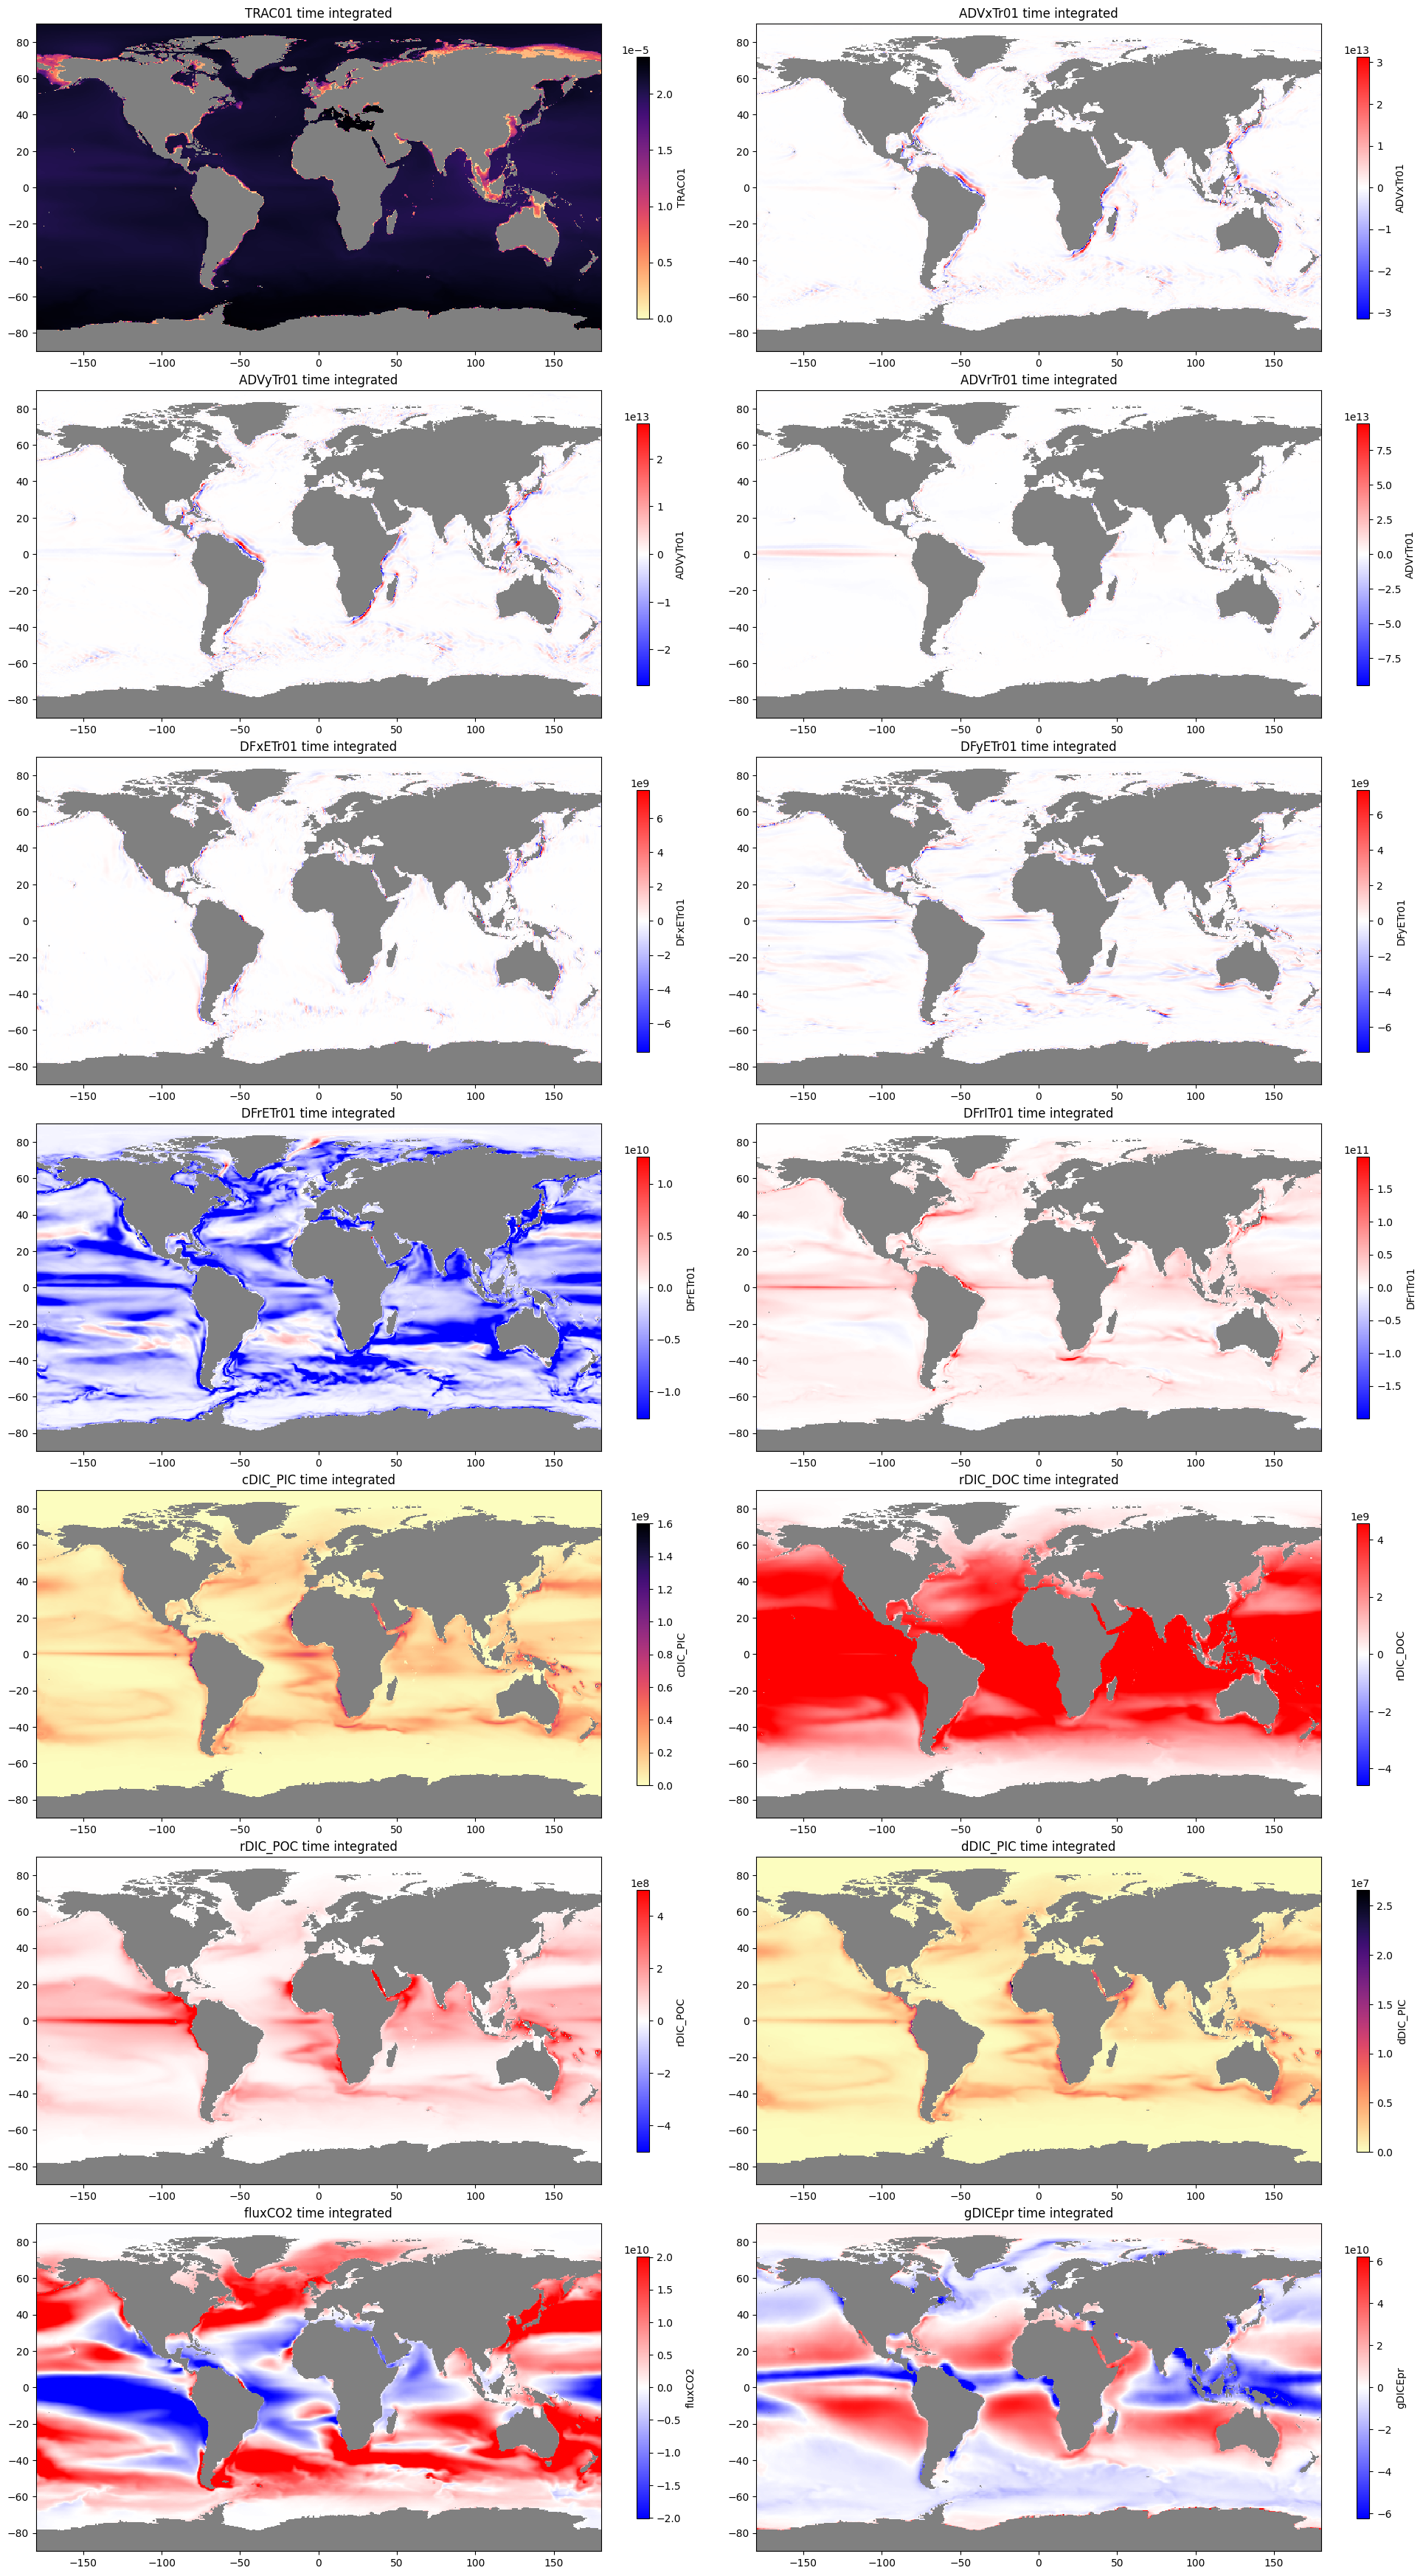

In [6]:
# PLotting time integrated plots
fig, axes = plt.subplots(7,2 , figsize=(20, 35))
axes = axes.flatten()

# iterate using utils functions
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = time_integrated_variables_final[var_idx]
    
    var_max = np.nanmax(time_integrated_variables_final[var_idx])
    var_min = np.nanmin(time_integrated_variables_final[var_idx])
    
    if np.isclose(var_min,0) or var_name=="TRAC01":
        vmax,vmin,cmap  = np.nanmax(time_integrated_variables_final[var_idx]), 0, cmap_magma
    else:
        vmax = np.nanmax(time_integrated_variables_final[var_idx])*0.3
        vmin = -vmax
        cmap = cmap_bwr
    
    p = ax.pcolormesh(lon_cart, lat_cart, time_integrated_variables_final[var_idx], cmap=cmap, vmax=vmax, vmin=vmin)
    ax.set_title(f"{var_name} time integrated")
    cbar = plt.colorbar(p, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(var_name)

plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.7) 
plt.savefig("outputs/plots/time integrated variables.png", dpi=250, bbox_inches="tight")
plt.show()

#### Calculating 10-30 clusters using k-means

In [7]:
clustering_data = time_integrated_variables_final[1:,:,:]
clustering_data.shape

(13, 360, 720)

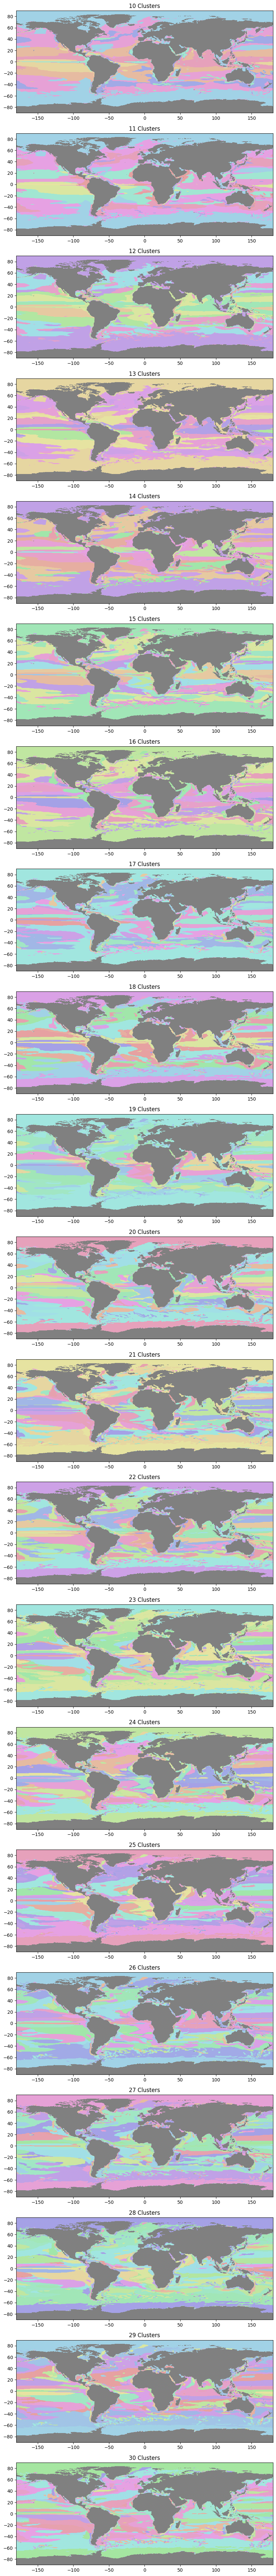

In [8]:
clustering_data = time_integrated_variables_final[1:,:,:]
# converting the data to 2D array
n_vars, lat_size, lon_size = clustering_data.shape  # (14, 360, 720)
data_reshaped = clustering_data.reshape(n_vars, -1).T  # Shape: (360×720, 14)

mask = np.isnan(data_reshaped[:, 0]) # Getting mask to exclude land
scaler = StandardScaler()
data_reshaped[~mask] = scaler.fit_transform(data_reshaped[~mask]) # Scaling everything that's not land

min_clusters = 10
max_clusters = 31

fig, ax = plt.subplots(max_clusters-min_clusters,1,figsize=(10, 100))

for i,n_clusters in enumerate(range(min_clusters,max_clusters)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = np.full(data_reshaped.shape[0], -1)  # Initialize labels as all -1 (land). anything not -1 would belong to cluster
    labels[~mask] = kmeans.fit_predict(data_reshaped[~mask])  # Cluster ocean points
    
    cluster_map = labels.reshape(lat_size, lon_size).astype(float)
    cluster_map[cluster_map == -1] = np.nan

    p = ax[i].pcolormesh(lon_cart, lat_cart, cluster_map, cmap=generate_pastel_cmap(max_clusters))
    ax[i].set_title(f"{n_clusters} Clusters")
    
    # plt.show()
    # plot_pcolor(ax=ax[i], values=cluster_map, lon=np.linspace(-180, 180, lon_size),
    #             lat=np.linspace(-90, 90, lat_size), var_name=f"Clusters = {n_clusters}", cmap="Set3_r",vmin=0,vmax=np.max(labels))

# plt.savefig("outputs/plots/Clustering result.png", dpi=500, bbox_inches="tight")
plt.show()

#### Explaining the clusters

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Only use valid points
X = data_reshaped[~mask]
y = labels[~mask]

# Fit multinomial logistic regression
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X, y)

# Coefficients
coefs = clf.coef_  # shape: (n_clusters, n_features)
coefs

array([[-1.41602735e+00, -1.74664788e+00, -2.94133232e-01,
         7.02719095e-01, -9.64909244e-01,  4.33892009e+00,
        -5.31279397e+00,  3.63008322e+00,  7.94464223e+00,
         3.78417686e+00,  2.04694514e+00, -2.61789884e+00,
         5.41053602e+00],
       [ 3.21849862e+00,  8.40903164e-01, -4.10076893e-02,
         8.04718936e-01,  9.17482988e-02,  5.31394747e+00,
        -3.38183046e+00, -5.10941698e+00, -6.54322631e+00,
        -5.39162127e+00, -5.71188408e+00,  1.01407528e+00,
        -2.61168985e+00],
       [-6.70179317e+00, -2.73539530e+00, -2.75422097e+00,
         2.66497021e+00, -2.00802676e+00,  4.80663066e+00,
        -3.63722975e+00, -3.52751159e+00,  9.08231434e+00,
        -5.24126295e-01, -6.45026006e+00, -1.51922523e+01,
         5.74847014e+00],
       [-3.04729056e-01, -1.52012788e+00, -1.34573347e+00,
        -4.15045288e+00, -8.22315957e+00, -6.01246061e+00,
         1.76065636e+00, -2.35562102e+00, -5.52079175e-01,
        -2.25745395e+00, -2.07192649e

In [10]:
import pandas as pd

# Importance: sum of absolute coefficients across all clusters
importance = np.sum(np.abs(coefs), axis=0)

# Create a nice DataFrame
importance_df = pd.DataFrame({
    'variable': variable_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

importance_df

ValueError: All arrays must be of the same length

In [14]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

def get_per_cluster_feature_importance(X, labels, variable_names):
    """
    For each cluster, trains a 1-vs-rest logistic regression
    and returns a DataFrame with variable importances per cluster.
    
    Args:
        X: (n_samples, n_features) standardized input data
        labels: (n_samples,) cluster labels
        variable_names: list of variable names
        
    Returns:
        importance_df: (n_clusters, n_features) DataFrame
    """
    n_clusters = np.max(labels) + 1
    n_features = X.shape[1]
    
    importance_matrix = np.zeros((n_clusters, n_features))
    
    for cluster_id in range(n_clusters):
        # Create binary target: 1 if belongs to cluster, else 0
        y_binary = (labels == cluster_id).astype(int)
        
        clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500)
        clf.fit(X, y_binary)
        
        importance_matrix[cluster_id, :] = np.abs(clf.coef_[0])  # take absolute value of coefficients
    
    # Convert to a DataFrame for easy viewing
    importance_df = pd.DataFrame(importance_matrix, columns=variable_names)
    importance_df.index = [f"Cluster {i}" for i in range(n_clusters)]
    
    return importance_df

importance_df = get_per_cluster_feature_importance(data_reshaped[~mask], labels[~mask], variable_names)

In [15]:
importance_df

TRAC01  ADVxTr01  ADVyTr01  ADVrTr01  DFxETr01  DFyETr01  \
Cluster 0   0.439854  0.157343  0.495634  0.166127  1.292289  2.693202   
Cluster 1   2.763095  1.058154  0.399159  0.075117  1.078626  4.610978   
Cluster 2   1.960800  2.687458  0.352131  0.114437  0.390942  0.555278   
Cluster 3   0.514268  0.340493  0.064016  0.086437  0.524926  1.376614   
Cluster 4   0.453411  1.366585  0.047945  0.033550  0.162572  0.055600   
Cluster 5   1.263926  2.645696  0.114370  0.308841  0.282171  0.495746   
Cluster 6   0.159184  2.542531  0.086252  0.374089  0.032663  0.890714   
Cluster 7   2.594863  0.116746  0.267513  0.026235  0.066240  0.381870   
Cluster 8   0.380180  0.256584  0.081338  0.088228  0.080971  0.397507   
Cluster 9   3.763194  0.498679  0.123361  0.018340  0.198180  0.237106   
Cluster 10  1.109818  0.100254  0.685588  0.112068  1.182469  0.598571   
Cluster 11  0.079055  0.233952  0.024241  0.015861  0.173958  0.160746   
Cluster 12  0.029599  0.085634  0.153250  0.321390  0.142038  0.027314   
Cluster 13  0.373326  0.088202  0.015096  0.030577  0.277764  1.351257   
Cluster 14  0.171237  0.415818  0.091005  0.041329  0.093566  0.237083   
Cluster 15  0.289131  0.030557  0.055629  0.049267  0.231638  0.635721   
Cluster 16  0.187143  0.786349  0.056392  0.436166  0.367349  0.763841   
Cluster 17  1.088194  0.056460  0.082587  0.022591  0.077742  0.084041   
Cluster 18  6.798596  1.455195  0.335060  0.017594  0.277591  0.416845   
Cluster 19  0.790372  0.248489  0.144370  0.008077  2.717458  0.562589   
Cluster 20  0.013752  0.154823  0.095288  1.273605  0.171094  0.061010   
Cluster 21  1.317353  0.338261  0.133142  0.081334  0.343734  0.626900   
Cluster 22  0.976853  0.067045  0.096551  0.090431  0.117046  0.014316   
Cluster 23  0.302816  0.145528  1.491975  0.210784  0.237459  0.122339   
Cluster 24  0.328678  0.004116  0.108119  0.003690  0.039932  0.136271   
Cluster 25  0.079311  1.792631  0.012787  0.127070  0.029378  0.115679   
Cluster 26  0.169619  0.041953  0.064212  0.093777  0.192481  0.345355   
Cluster 27  0.094666  0.555977  1.447743  0.097463  0.104577  0.107469   
Cluster 28  0.634206  0.129519  0.017810  0.036540  1.082997  0.253219   
Cluster 29  0.452534  0.016860  0.215223  0.066285  0.220469  0.960127   

            DFrETr01  DFrITr01   cDIC_PIC  respDIC  rDIC_DOC   rDIC_POC  \
Cluster 0   1.934518  1.432120   0.304347      0.0  4.244022  12.446614   
Cluster 1   4.424465  0.105197   0.750767      0.0  3.072485   5.549629   
Cluster 2   2.473545  1.102822   2.078040      0.0  8.381166   7.386582   
Cluster 3   0.101957  0.152309   2.930514      0.0  2.188970   3.080177   
Cluster 4   1.583953  0.589761   1.747824      0.0  3.953999   0.253451   
Cluster 5   2.001463  1.606605  15.195170      0.0  1.050385   2.297140   
Cluster 6   0.756546  0.326209   0.808164      0.0  5.016441   1.833200   
Cluster 7   0.564042  0.609276   1.757495      0.0  2.064022   0.844338   
Cluster 8   0.826572  0.371072   2.485798      0.0  0.462949   2.474965   
Cluster 9   1.592374  0.070123   2.038117      0.0  0.048426   0.057972   
Cluster 10  0.042120  0.691130   0.833559      0.0  0.172736   0.257926   
Cluster 11  0.016538  0.240680   0.077488      0.0  0.082642   0.219506   
Cluster 12  0.073037  0.081589   0.162162      0.0  0.113357   0.163150   
Cluster 13  0.787374  0.005862   0.894570      0.0  1.262537   3.539953   
Cluster 14  0.009018  0.292439   0.439012      0.0  0.320027   0.656425   
Cluster 15  0.715099  0.417921   0.951108      0.0  4.496251   7.888438   
Cluster 16  0.815715  0.667981   1.131457      0.0  0.774083   0.980429   
Cluster 17  1.001586  0.043187   0.562263      0.0  1.294207   2.814988   
Cluster 18  0.415691  1.059878   0.635638      0.0  5.257706   2.242949   
Cluster 19  0.966579  0.370778   0.174898      0.0  1.323748   2.759791   
Cluster 20  0.288359  0.276476   0.103715      0.0  0.014594   0.011653   
Cluster 21  1.196503  0.686918   3.039505      0.0  2.792880   0.2813

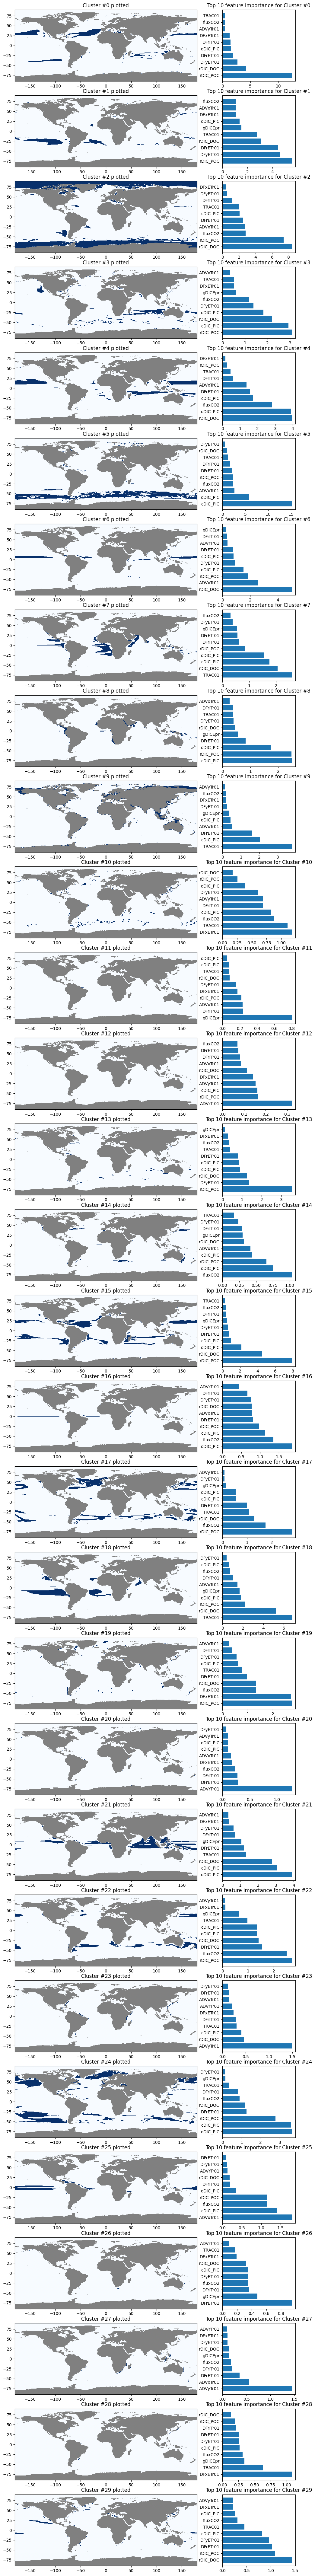

In [93]:
fig, ax = plt.subplots(30,2, figsize=(12, 110),gridspec_kw={'width_ratios': [2.5, 1]})

for cluster in range(30):
    selected = cluster_map.copy()
    mask = (selected != cluster) & (~np.isnan(selected))
    selected[selected == cluster] = 100
    selected[mask] = 0
    
    cmap_blues = mpl.colormaps.get_cmap('Blues')  
    cmap_blues.set_bad(color='gray') # sets "bad" (i.e., NaNs) to be colored in gray

    p = ax[cluster,0].pcolormesh(
            lon_cart, lat_cart, selected, cmap=cmap_blues)
    ax[cluster, 0].set_title(f"Cluster #{cluster} plotted")
    
    top_vars = importance_df.iloc[cluster].sort_values(ascending=False).head(10)
    ax[cluster,1].barh(top_vars.index, top_vars.values)
    ax[cluster, 1].set_title(f"Top 10 feature importance for Cluster #{cluster}")
plt.savefig("outputs/plots/Clustering feature importance.png", dpi=300, bbox_inches="tight")